In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
import os

In [26]:
eval_results_dir = "/Users/davidkorcak/Documents/ctu/bachelors/flipper_training/cross_eval_results/final_coarse_gaussian_terrain_thesis_98_policy_final/"
eval_results_dir = Path(eval_results_dir)
fig_dest = Path("/Users/davidkorcak/Documents/ctu/bachelors/bachelor_thesis/figures")

In [27]:
results_dict = {}
for f in eval_results_dir.glob("*.pkl"):
    with open(f, "rb") as r:
        results = pickle.load(r)  # noqa
    results_dict[f.stem] = results

In [28]:
def list_of_dicts_to_dict_of_lists(list_of_dicts):
    """
    Convert a list of dictionaries to a dictionary of lists.
    """
    dict_of_lists = {}
    for d in list_of_dicts:
        for k, v in d.items():
            if k not in dict_of_lists:
                dict_of_lists[k] = []
            dict_of_lists[k].append(v)
    return dict_of_lists

In [29]:
key2name = {
    "file_natural": "Natural Terrain",
    "file_natural_cracks": "Natural Cracked Terrain",
    "file_ridge": "Cliff Terrain",
    "file_sine": "Valley Terrain",
}

In [30]:
results_transposed = {k: list_of_dicts_to_dict_of_lists(v) for k, v in results_dict.items()}
results_transposed.keys()

dict_keys(['stairs_easy', 'file_sine', 'stairs_hard', 'barrier_easy', 'file_natural_cracks', 'gauss_coarse_easy', 'file_ridge', 'gauss_fine_hard', 'trunk_hard', 'file_natural', 'gauss_fine_easy', 'trunk_easy', 'training', 'gauss_coarse_hard', 'barrier_hard'])

In [31]:
import matplotlib

matplotlib.rcParams["text.usetex"] = True

key_labels = list(key2name.values()) + ["All"]
step_size = 1
width = 0.4
tickfontsize = 28
labelfontsize = 45
ylabelpad = 45

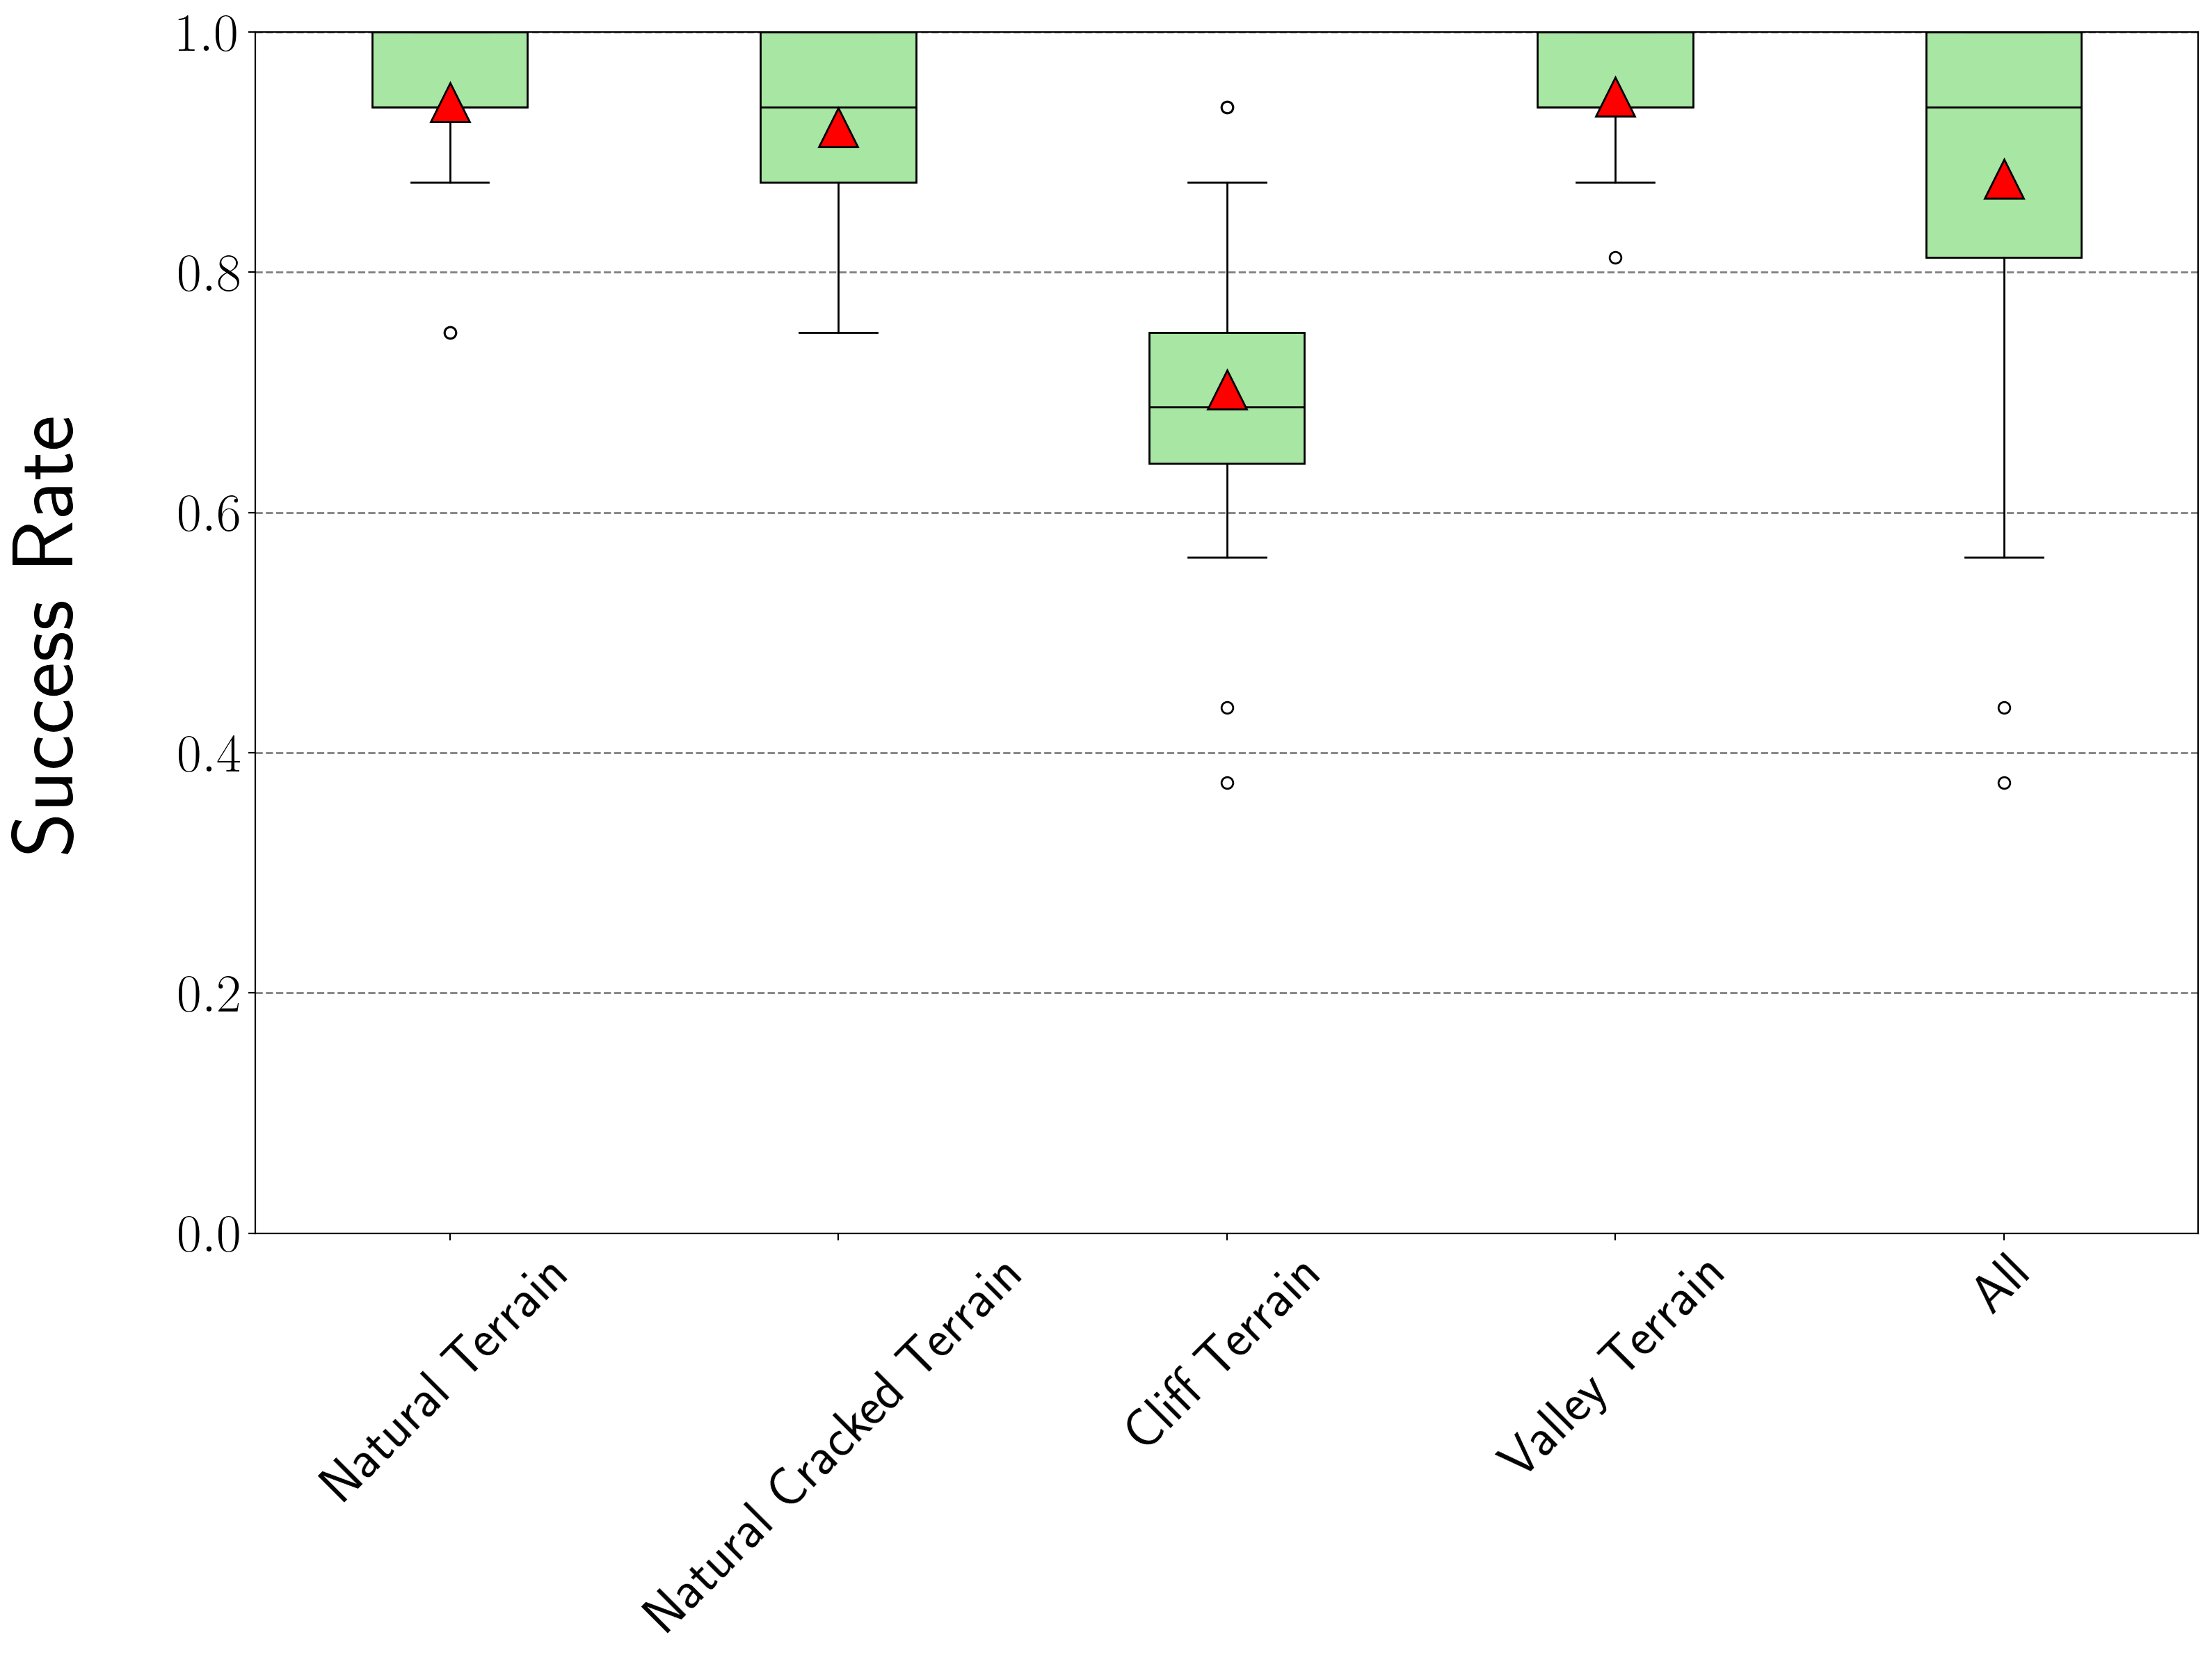

In [32]:
# Plot for easy + training
fig, ax = plt.subplots(1, 1, figsize=(16, 12), dpi=200)
ax.set_ylabel("Success Rate", fontsize=labelfontsize, labelpad=ylabelpad)
ax.set_ylim(0, 1)
green_color = "#a8e6a3"
line_color = "black"
meancolor = "#ff0000"
all_successes = []
for i, k in enumerate(key2name.keys()):
    v = results_transposed[k]
    pct_succeeded = v["eval/pct_succeeded"]
    all_successes.extend(pct_succeeded)
    ax.boxplot(
        pct_succeeded,
        positions=[i * step_size],
        widths=width,
        patch_artist=True,
        boxprops=dict(facecolor=green_color, color=line_color),
        medianprops=dict(color=line_color),
        meanprops=dict(markerfacecolor=meancolor, markeredgecolor="black", markersize=20),
        capprops=dict(color=line_color),
        whiskerprops=dict(color=line_color),
        showmeans=True,
    )
ax.boxplot(
    all_successes,
    positions=[len(key2name) * step_size],
    widths=width,
    patch_artist=True,
    boxprops=dict(facecolor=green_color, color=line_color),
    medianprops=dict(color=line_color),
    meanprops=dict(markerfacecolor=meancolor, markeredgecolor="black", markersize=20),
    capprops=dict(color=line_color),
    whiskerprops=dict(color=line_color),
    showmeans=True,
)
ax.set_xticks(range(len(key2name) + 1))
ax.set_xticklabels(key_labels, rotation=45, fontsize=tickfontsize)
ax.tick_params(axis="y", labelsize=tickfontsize)
ax.yaxis.grid(True, which="major", linestyle="--", linewidth=1, color="gray")
ax.xaxis.grid(False)
plt.tight_layout()
plt.savefig(fig_dest / f"{eval_results_dir.stem}_realistic_success.pdf", bbox_inches="tight")
plt.show()

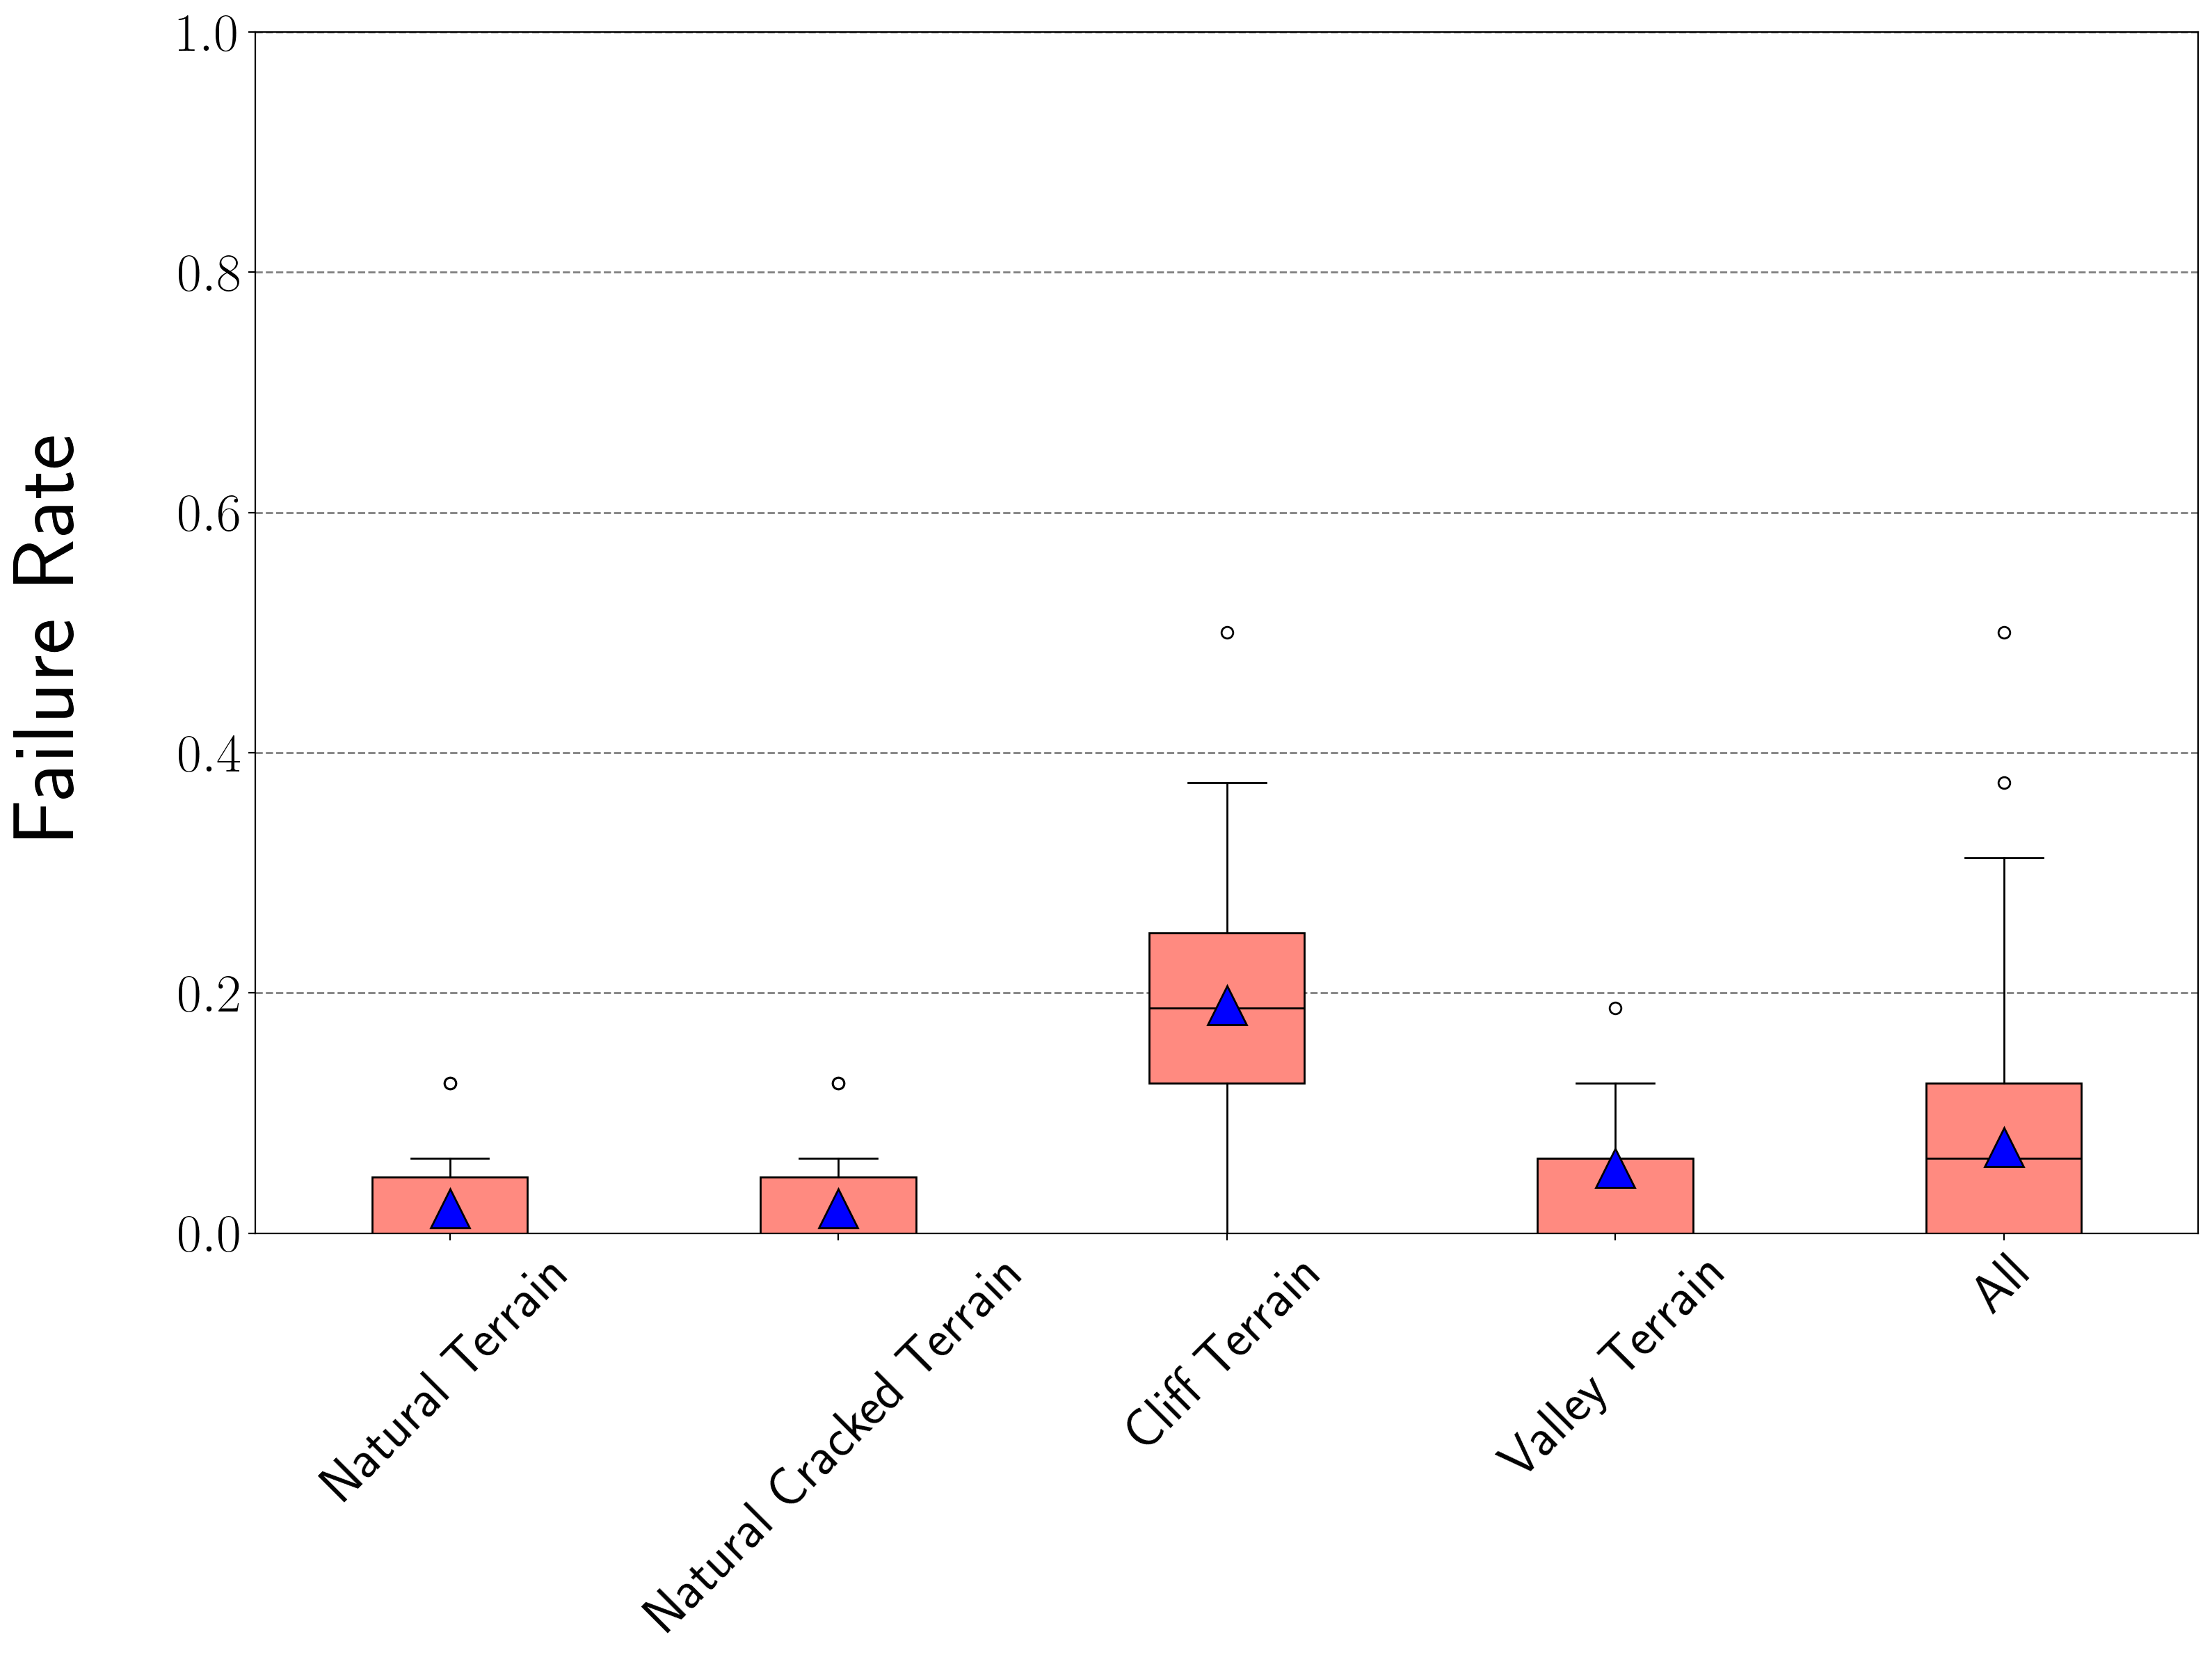

In [33]:
# Plot Failure Rate across all environments
fig, ax = plt.subplots(1, 1, figsize=(16, 12), dpi=200)
ax.set_ylabel("Failure Rate", fontsize=labelfontsize, labelpad=ylabelpad)
ax.set_ylim(0, 1)
red_color = "#ff8a80"
line_color = "black"
meancolor = "#0000ff"
all_failures = []
for i, k in enumerate(key2name.keys()):
    v = results_transposed[k]
    pct_failed = v["eval/pct_failed"]
    all_failures.extend(pct_failed)
    ax.boxplot(
        pct_failed,
        positions=[i * step_size],
        widths=width,
        patch_artist=True,
        boxprops=dict(facecolor=red_color, color=line_color),
        medianprops=dict(color=line_color),
        meanprops=dict(markerfacecolor=meancolor, markeredgecolor="black", markersize=20),
        capprops=dict(color=line_color),
        whiskerprops=dict(color=line_color),
        showmeans=True,
    )
# overall "All" box
ax.boxplot(
    all_failures,
    positions=[len(key2name) * step_size],
    widths=width,
    patch_artist=True,
    boxprops=dict(facecolor=red_color, color=line_color),
    medianprops=dict(color=line_color),
    meanprops=dict(markerfacecolor=meancolor, markeredgecolor="black", markersize=20),
    capprops=dict(color=line_color),
    whiskerprops=dict(color=line_color),
    showmeans=True,
)
ax.set_xticks(range(len(key2name) + 1))
ax.set_xticklabels(key_labels, rotation=45, fontsize=tickfontsize)
ax.tick_params(axis="y", labelsize=tickfontsize)
ax.yaxis.grid(True, which="major", linestyle="--", linewidth=1, color="gray")
ax.xaxis.grid(False)
plt.tight_layout()
plt.savefig(fig_dest / f"{eval_results_dir.stem}_realistic_failure.pdf", bbox_inches="tight")
plt.show()

In [34]:
import numpy as np
from pathlib import Path

# Ensure the base evaluation directory is defined (as in your script)

# Define a directory to save the .tex table files
tables_output_dir = fig_dest.parent / "tables"
os.makedirs(tables_output_dir, exist_ok=True)


def compute_dual_metric_stats(
    env_data_keys_to_process,  # List of raw keys: e.g., ["training", "stairs_easy"] (without "All")
    full_results_data,  # results_transposed
    environment_name_mapping,  # key2name
):
    """
    Computes mean and standard deviation for success and failure rates across specified environments.
    Also calculates an "All" aggregate for these environments.
    Returns a dictionary structured as: {env_display_name: {"success": (mean, std), "failure": (mean, std)}, ...}
    The "All" key in the returned dictionary contains aggregated stats.
    """
    stats_by_env_then_metric = {}  # {display_name: {"success": (m,s), "failure": (m,s)}, ...}

    overall_success_values = []
    overall_failure_values = []

    for env_key in env_data_keys_to_process:  # Iterate through specific environments first
        display_name = environment_name_mapping.get(env_key)
        if display_name is None:
            print(f"Warning: No display name found for environment key '{env_key}' in key2name. Skipping.")
            stats_by_env_then_metric[env_key] = {"success": (np.nan, np.nan), "failure": (np.nan, np.nan)}  # Store with raw key if no display name
            continue

        stats_by_env_then_metric[display_name] = {}

        # Success metric
        if env_key in full_results_data and "eval/pct_succeeded" in full_results_data[env_key]:
            success_values = full_results_data[env_key]["eval/pct_succeeded"]
            if success_values:  # Ensure list is not empty
                mean_s = np.mean(success_values) * 100
                std_s = np.std(success_values) * 100
                stats_by_env_then_metric[display_name]["success"] = (mean_s, std_s)
                if env_key != "training":  # Exclude training from overall stats
                    overall_success_values.extend(success_values)  # Add to overall list for "All" calculation
            else:
                stats_by_env_then_metric[display_name]["success"] = (np.nan, np.nan)
        else:
            print(f"Warning: Success metric 'eval/pct_succeeded' not found for env '{env_key}'. Stats for '{display_name}' success will be NaN.")
            stats_by_env_then_metric[display_name]["success"] = (np.nan, np.nan)

        # Failure metric
        if env_key in full_results_data and "eval/pct_failed" in full_results_data[env_key]:
            failure_values = full_results_data[env_key]["eval/pct_failed"]
            if failure_values:  # Ensure list is not empty
                mean_f = np.mean(failure_values) * 100
                std_f = np.std(failure_values) * 100
                stats_by_env_then_metric[display_name]["failure"] = (mean_f, std_f)
                if env_key != "training":  # Exclude training from overall stats
                    overall_failure_values.extend(failure_values)  # Add to overall list for "All" calculation
            else:
                stats_by_env_then_metric[display_name]["failure"] = (np.nan, np.nan)
        else:
            print(f"Warning: Failure metric 'eval/pct_failed' not found for env '{env_key}'. Stats for '{display_name}' failure will be NaN.")
            stats_by_env_then_metric[display_name]["failure"] = (np.nan, np.nan)

    # Calculate "All" category stats from all collected values
    all_key = "All"
    stats_by_env_then_metric[all_key] = {}
    if overall_success_values:
        mean_all_s = np.mean(overall_success_values) * 100
        std_all_s = np.std(overall_success_values) * 100
        stats_by_env_then_metric[all_key]["success"] = (mean_all_s, std_all_s)
    else:
        print("Warning: No data aggregated for 'All' success category. Stats will be NaN.")
        stats_by_env_then_metric[all_key]["success"] = (np.nan, np.nan)

    if overall_failure_values:
        mean_all_f = np.mean(overall_failure_values) * 100
        std_all_f = np.std(overall_failure_values) * 100
        stats_by_env_then_metric[all_key]["failure"] = (mean_all_f, std_all_f)
    else:
        print("Warning: No data aggregated for 'All' failure category. Stats will be NaN.")
        stats_by_env_then_metric[all_key]["failure"] = (np.nan, np.nan)

    return stats_by_env_then_metric


def create_latex_table_new_format(
    stats_per_env,  # Dict from compute_dual_metric_stats: {env_display_name: {"success": (m,s), "failure": (m,s)}, ...}
    ordered_env_display_names,  # List of display names in desired row order, e.g., ["Training Dist", ..., "All"]
    caption_text,
    label_text,
    font_size="\\footnotesize",
):
    """
    Generates a LaTeX table string with environments as rows and MSR/MFR as columns.
    """
    latex_code = "\\begin{table}[H]\n"
    latex_code += "\\centering\n"
    latex_code += f"{font_size}\n"
    # 'l' for environment name (left-aligned), 'c' for MSR, 'c' for MFR (center-aligned)
    latex_code += "\\begin{tabular}{lcc}\n"
    latex_code += "\\toprule\n"
    latex_code += "Environment & Success Rate (\\%) $\\pm 1 \\sigma$ & Failure Rate (\\%) $\\pm 1 \\sigma$ \\\\\n"
    latex_code += "\\midrule\n"

    for env_display_name in ordered_env_display_names:
        env_metrics = stats_per_env.get(env_display_name, {})  # Get stats for the current display name

        success_data = env_metrics.get("success", (np.nan, np.nan))
        failure_data = env_metrics.get("failure", (np.nan, np.nan))

        msr_entry = "N/A"
        if not np.isnan(success_data[0]) and not np.isnan(success_data[1]):
            msr_entry = f"${success_data[0]:.2f} \\pm {success_data[1]:.2f}$"

        mfr_entry = "N/A"
        if not np.isnan(failure_data[0]) and not np.isnan(failure_data[1]):
            mfr_entry = f"${failure_data[0]:.2f} \\pm {failure_data[1]:.2f}$"

        latex_code += f"{env_display_name} & {msr_entry} & {mfr_entry} \\\\\n"

    latex_code += "\\bottomrule\n"
    latex_code += "\\end{tabular}\n"
    latex_code += f"\\caption{{{caption_text}}}\n"
    latex_code += f"\\label{{{label_text}}}\n"
    latex_code += "\\end{table}\n"

    return latex_code


# --- Revised configuration: single “Realistic Environments” table ---
table_configurations_new = [
    {
        "type": "Realistic Environments Metrics",
        "env_data_keys_to_process": list(key2name.keys()),
        "ordered_env_display_names": key_labels,  # uses the names + "All"
        "caption": "Success and failure rate statistics for realistic environments aggregated over multiple evaluation seeds.",
        "label_suffix": "_realistic_metrics",
        "filename_suffix": "_realistic_metrics.tex",
    },
]

# --- Generate and save/print the table ---
for config in table_configurations_new:
    print(f"--- Generating table for: {config['type']} ---")
    current_env_stats = compute_dual_metric_stats(
        env_data_keys_to_process=config["env_data_keys_to_process"],
        full_results_data=results_transposed,
        environment_name_mapping=key2name,
    )
    table_label_str = f"tab:{eval_results_dir.stem}{config['label_suffix']}"
    latex_output_str = create_latex_table_new_format(
        stats_per_env=current_env_stats,
        ordered_env_display_names=config["ordered_env_display_names"],
        caption_text=config["caption"],
        label_text=table_label_str,
    )
    output_file_path = tables_output_dir / f"{eval_results_dir.stem}{config['filename_suffix']}"
    with open(output_file_path, "w") as f_out:
        f_out.write(latex_output_str)
    print(f"Saved {config['type']} table to: {output_file_path}\n")
    print(latex_output_str)
    print("-" * 50 + "\n")

print(f"All new format LaTeX tables have been generated and saved in: {tables_output_dir}")

--- Generating table for: Realistic Environments Metrics ---
Saved Realistic Environments Metrics table to: /Users/davidkorcak/Documents/ctu/bachelors/bachelor_thesis/tables/final_coarse_gaussian_terrain_thesis_98_policy_final_realistic_metrics.tex

\begin{table}[H]
\centering
\footnotesize
\begin{tabular}{lcc}
\toprule
Environment & Success Rate (\%) $\pm 1 \sigma$ & Failure Rate (\%) $\pm 1 \sigma$ \\
\midrule
Natural Terrain & $94.17 \pm 6.24$ & $2.08 \pm 3.73$ \\
Natural Cracked Terrain & $92.08 \pm 8.06$ & $2.08 \pm 3.73$ \\
Cliff Terrain & $70.21 \pm 12.36$ & $18.96 \pm 10.64$ \\
Valley Terrain & $94.58 \pm 5.29$ & $5.42 \pm 5.29$ \\
All & $87.76 \pm 13.22$ & $7.14 \pm 9.52$ \\
\bottomrule
\end{tabular}
\caption{Success and failure rate statistics for realistic environments aggregated over multiple evaluation seeds.}
\label{tab:final_coarse_gaussian_terrain_thesis_98_policy_final_realistic_metrics}
\end{table}

--------------------------------------------------

All new format La